# Data Clustering Notebook


In [2]:
from sklearn.neighbors import BallTree
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
#from fastcluster import linkage
from scipy.cluster.hierarchy import linkage # to avoid having to install fastcluster, though would be speedier...

### Import data

In [3]:
#df = pd.read_csv("../JET_EFIT_magnetic/all_data.csv",index_col=0)

list_pulse_files = [
    "../JET_EFIT_magnetic/99002.csv",
    "../JET_EFIT_magnetic/99022.csv",
    "../JET_EFIT_magnetic/99032.csv",
    "../JET_EFIT_magnetic/99042.csv",
    "../JET_EFIT_magnetic/99052.csv",
    "../JET_EFIT_magnetic/99061.csv",
    "../JET_EFIT_magnetic/99071.csv",
]

df_list = []

for pulse in list_pulse_files:
    df = pd.read_csv(pulse)
    df_list.append(df)
    

final_df = pd.concat(df_list)
    
df = final_df
    
print(df.shape)
print(df.head())





(6210, 44)
     BPME_0    BPME_1   BPME_10   BPME_11   BPME_12   BPME_13   BPME_14  \
0 -0.000300 -0.000073 -0.029262 -0.016462 -0.037248 -0.150205  0.004801   
1  0.000048 -0.000011 -0.001109 -0.001907 -0.048215 -0.169726 -0.006147   
2 -0.000508 -0.000035 -0.000337 -0.012987 -0.065121 -0.145824 -0.006780   
3  0.000065  0.000038 -0.000154 -0.012527 -0.077156 -0.098357 -0.011316   
4 -0.000235  0.000095 -0.001572  0.000508 -0.089823 -0.055632  0.002902   

    BPME_15   BPME_16   BPME_17  ...    FLME_9      BVAC       FLX       IPLA  \
0 -0.066183  0.012603 -0.078581  ... -0.115637 -2.697513  0.004968 -509648.50   
1 -0.120968  0.000284 -0.001036  ... -0.005630 -2.697913  0.005581 -534308.70   
2 -0.176529 -0.124070 -0.126869  ...  0.012122 -2.698714  0.005829 -563830.20   
3 -0.184514 -0.112982 -0.123344  ...  0.164736 -2.701315  0.007070 -600781.60   
4 -0.151831 -0.088228 -0.095304  ...  0.074797 -2.702033  0.007848 -634319.06   

    Time      FAXS      FBND           P       DFDP

### Transform to dynamic time warping
(we need each pulse to be a data point, not sample from within them? not sure, check with bigger dataset)
which is why I think this pre-cluster analysis came out badly

## Pre-clustering Analysis


### Plot inspection

Reduce dimensionality so we get scatter plots and can visually inspect for meaningful clusters.

[0.09079703 0.07107097]
[157.50993445 139.35362034]
(6210, 44)
(6210, 2)


Text(0, 0.5, 'dim 2')

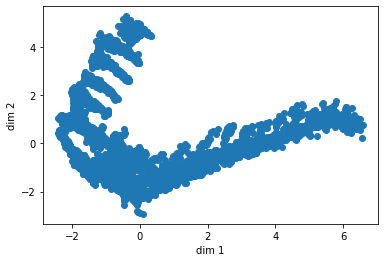

In [4]:
X = df

# need to scale data before PCA
# probs don't need to normalise https://stats.stackexchange.com/questions/385775/normalizing-vs-scaling-before-pca
scaler = StandardScaler()
scaler.fit(X)
scaled_X = scaler.transform(X)

# apply pca
pca = PCA(n_components=2)
pca.fit(scaled_X)
print(pca.explained_variance_ratio_)
# The amount of variance explained by each of the selected components. 

print(pca.singular_values_)
# The singular values corresponding to each of the selected components.

# make some nice plots (sns pairplot?)

pca_X = pca.transform(scaled_X)

print(X.shape)
print(pca_X.shape)

plt.scatter(pca_X[:,0],pca_X[:,1])
plt.xlabel('dim 1')
plt.ylabel('dim 2')


(6210, 2)
             0         1
0    -0.668086  4.249362
1    -0.698738  4.306977
2    -0.745760  4.269554
3    -0.817398  4.230943
4    -0.909814  4.126674
...        ...       ...
6200  5.645916  1.276023
6201  5.663485  1.323736
6202  6.044646  1.447577
6203  5.715280  1.451227
6204  5.732426  1.346310

[6205 rows x 2 columns]
(997, 2)
(952, 2)
            0         1
0   -0.668086  4.249362
1   -0.698738  4.306977
2   -0.745760  4.269554
3   -0.817398  4.230943
4   -0.909814  4.126674
..        ...       ...
987  5.715305  1.556919
988  5.757664  1.614737
989  5.792979  1.738725
990  6.136987  1.007909
991  6.097469  1.002188

[992 rows x 2 columns]


Text(0, 0.5, 'dim 2')

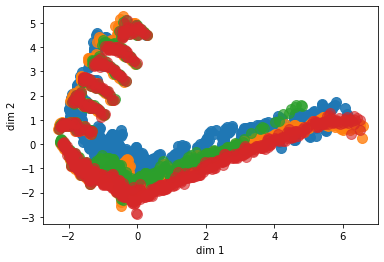

In [29]:
# same again with labels

labelled_pca = pd.DataFrame(pca_X)


"""
labelled_pca['label'] = '0'
labelled_pca.loc[labelled_pca.index[0:928],'label'] = 'pulse1'
labelled_pca.loc[labelled_pca.index[929:1856],'label'] = 'pulse2'
"""
print(labelled_pca.shape)


print(labelled_pca.head(-5))
#pulse1_df = labelled_pca.loc[labelled_pca.index[0:927]]
#pulse2_df = labelled_pca.loc[labelled_pca.index[928:1856]]

pulse1_df = labelled_pca.loc[labelled_pca.index[0:997]]
pulse2_df = labelled_pca.loc[labelled_pca.index[998:1950]]
pulse3_df = labelled_pca.loc[labelled_pca.index[1951:2796]]
pulse4_df = labelled_pca.loc[labelled_pca.index[2797:3755]]

print(pulse1_df.shape)
print(pulse2_df.shape)

print(pulse1_df.head(-5))

# double check indexing here, should be 927 in pulse 1 

plt.scatter(pulse1_df.iloc[:,0],pulse1_df.iloc[:,1],s=100,alpha=0.9)
plt.scatter(pulse2_df.iloc[:,0],pulse2_df.iloc[:,1],s=100,alpha=0.8)
plt.scatter(pulse3_df.iloc[:,0],pulse3_df.iloc[:,1],s=100,alpha=0.7)
plt.scatter(pulse4_df.iloc[:,0],pulse4_df.iloc[:,1],s=100,alpha=0.6)
plt.xlabel('dim 1')
plt.ylabel('dim 2')




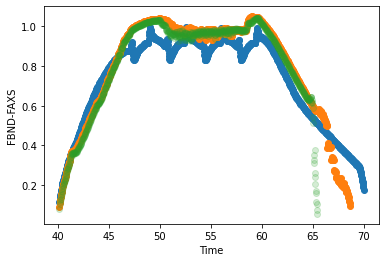

"\n# below not valid I think\npca_A = pca.transform(pulse_A)\npca_B = pca.transform(pulse_B)\npca_C = pca.transform(pulse_C)\n\npca_A = pd.DataFrame(pca_A)\npca_B = pd.DataFrame(pca_B)\npca_C = pd.DataFrame(pca_C)\n\n\nplt.scatter(pca_A.iloc[:,0],pca_A.iloc[:,1],s=100,alpha=0.9)\nplt.scatter(pca_B.iloc[:,0],pca_B.iloc[:,1],s=100,alpha=0.2)\nplt.scatter(pca_C.iloc[:,0],pca_.iloc[:,1],s=100,alpha=0.2)\nplt.xlabel('dim 1')\nplt.ylabel('dim 2')\n"

In [30]:
"""
for pulse in list_pulse_files:
    df = pd.read_csv(pulse)
    plt.scatter(df['FBND'],df['Time'])
"""    

pulse_A = pd.read_csv("../JET_EFIT_magnetic/99002.csv")
pulse_B = pd.read_csv("../JET_EFIT_magnetic/99022.csv")
pulse_C = pd.read_csv("../JET_EFIT_magnetic/99032.csv")

plt.scatter(pulse_A['Time'],pulse_A['FBND-FAXS'])
plt.scatter(pulse_B['Time'],pulse_B['FBND-FAXS'])
plt.scatter(pulse_C['Time'],pulse_C['FBND-FAXS'],alpha=0.2)
plt.xlabel('Time')
plt.ylabel('FBND-FAXS')

plt.show()

"""
# below not valid I think
pca_A = pca.transform(pulse_A)
pca_B = pca.transform(pulse_B)
pca_C = pca.transform(pulse_C)

pca_A = pd.DataFrame(pca_A)
pca_B = pd.DataFrame(pca_B)
pca_C = pd.DataFrame(pca_C)


plt.scatter(pca_A.iloc[:,0],pca_A.iloc[:,1],s=100,alpha=0.9)
plt.scatter(pca_B.iloc[:,0],pca_B.iloc[:,1],s=100,alpha=0.2)
plt.scatter(pca_C.iloc[:,0],pca_.iloc[:,1],s=100,alpha=0.2)
plt.xlabel('dim 1')
plt.ylabel('dim 2')
"""

This doesn't look too clusterable...

Probably because we are taking every data point from each pulse, should probably consider pulses as singular data points.


### Hopkins statistic

(We caveat this as Hopkins is really a test to see whether the data is uniformly distributed and it is possible to get highly clustered non-uniform distributions. Equally a single gaussian would score well as a uniform distribution despite only having one 'cluster')

So really we are using it as a first test for distribution uniformity. 

Is a measure of the cluster tendency of a dataset.
- H ~ 1 = data is highly clustered
- H ~ 0.5 = data is random
- H ~ 0 = data is uniformly distributed (no meaningful clusters)


Python function nicked from: https://github.com/lachhebo/pyclustertend/blob/master/pyclustertend/hopkins.py

(double check this, also find an alternative at https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/)
#### And this implementation actually inverts the H criterion- so we are looking for ~0 as an expression of high clusterability!

Obeys eq. below where data is $d$ dimensional, $X$ is set of $n$ data points. $m$ is a random sample of data points where $ m << n $ of set $Y$.

$u_{i}$ is distance of $y_{i}$ (subset of $Y$) from nearest neighbour in $X$
$w_{i}$ is distance of $m$ number of $x_{i}$ (subset of $X$) points chosen from nearest neighbour in $X$

$$ H=\frac {\sum _{i=1}^{m}{u_{i}^{d}}}{\sum _{i=1}^{m}{u_{i}^{d}}+\sum _{i=1}^{m}{w_{i}^{d}}}$$

In [6]:
def hopkins(data_frame, sampling_size):
    """Assess the clusterability of a dataset. A score between 0 and 1, a score around 0.5 express
    no clusterability and a score tending to 0 express a high cluster tendency.
    Parameters
    ----------
    data_frame : numpy array
        The input dataset
    sampling_size : int
        The sampling size which is used to evaluate the number of DataFrame.
    Returns
    ---------------------
    score : float
        The hopkins score of the dataset (between 0 and 1)
    Examples
    --------
    >>> from sklearn import datasets
    >>> from pyclustertend import hopkins
    >>> X = datasets.load_iris().data
    >>> hopkins(X,150)
    0.16
    """

    if type(data_frame) == np.ndarray:
        data_frame = pd.DataFrame(data_frame)

    # Sample n observations from D : P

    if sampling_size > data_frame.shape[0]:
        raise Exception("The number of sample of sample is bigger than the shape of D")

    data_frame_sample = data_frame.sample(n=sampling_size)

    # Get the distance to their neirest neighbors in D : X

    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(data_frame_sample, k=2)
    data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]

    # Randomly simulate n points with the same variation as in D : Q.

    max_data_frame = data_frame.max()
    min_data_frame = data_frame.min()

    uniformly_selected_values_0 = np.random.uniform(
        min_data_frame[0], max_data_frame[0], sampling_size
    )
    uniformly_selected_values_1 = np.random.uniform(
        min_data_frame[1], max_data_frame[1], sampling_size
    )

    uniformly_selected_observations = np.column_stack(
        (uniformly_selected_values_0, uniformly_selected_values_1)
    )
    if len(max_data_frame) >= 2:
        for i in range(2, len(max_data_frame)):
            uniformly_selected_values_i = np.random.uniform(
                min_data_frame[i], max_data_frame[i], sampling_size
            )
            to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
            uniformly_selected_observations = np.column_stack(to_stack)

    uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)

    # Get the distance to their neirest neighbors in D : Y

    tree = BallTree(data_frame, leaf_size=2)
    dist, _ = tree.query(uniformly_selected_observations_df, k=1)
    uniformly_df_distances_to_nearest_neighbours = dist

    # return the hopkins score

    x = sum(data_frame_sample_distances_to_nearest_neighbours)
    y = sum(uniformly_df_distances_to_nearest_neighbours)

    if x + y == 0:
        raise Exception("The denominator of the hopkins statistics is null")

    return x / (x + y)[0]

In [7]:
hopkins(X,150)

0.16067714074069572

On local data (two pulses) we get 0.39 which indicates some potential clusterability.

### Visual Assessment of Cluster Tendency (VAT)


The algorithm of the visual assessment of cluster tendency (VAT) approach (Bezdek and Hathaway, 2002) is as follows:

1. Compute the dissimilarity (DM) matrix between the objects in the data set using the Euclidean distance measure
2. Reorder the DM so that similar objects are close to one another. This process create an ordered dissimilarity matrix (ODM)
3. The ODM is displayed as an ordered dissimilarity image (ODI), which is the visual output of VAT

There is a better though more computationally demanding algorithm called iVAT as well. 

Remember to use on scaled data. 

In [8]:
# Currently have 2 pulses so checking to see if it can tell difference between them
# label to distinguish between pulses
"""
X['label'] = '0'
X.loc[X.index[0:927],'label'] = 'pulse1'
X.loc[X.index[928:1855],'label'] = 'pulse2'
print(X.head(-5))
"""

"\nX['label'] = '0'\nX.loc[X.index[0:927],'label'] = 'pulse1'\nX.loc[X.index[928:1855],'label'] = 'pulse2'\nprint(X.head(-5))\n"

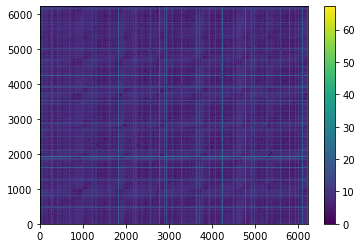

In [9]:
# borrowing heavily from https://gmarti.gitlab.io/ml/2017/09/07/how-to-sort-distance-matrix.html
# note this currently finds distance and not dissimilarity matrices, slightly different things: http://scikit-bio.org/docs/0.1.4/core.distance.html
# bc distance matrix needs to be symmetric

dist_mat = squareform(pdist(scaled_X))

N = len(scaled_X)
plt.pcolormesh(dist_mat)
plt.colorbar()
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()
#euclidean_distances(X, X)

This is the unsorted distance matrix.

It kind of implies that there are four clusters, one in each quadrant. Also implies that they are linearly separable, can chop into groups with straight lines. 

May correspond to ramp up/down and on mode per pulse? Check by adding another pulse, should jump to 2x3 then.

todo here: implement rest of gmarti to reorder matrix, need to install fastcluster

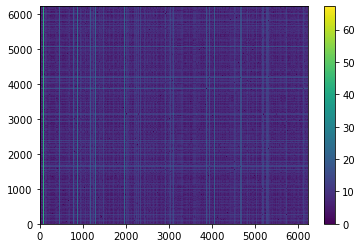

In [10]:
# randomly shuffling the data points to prove that sorting works

shuffle_X = scaled_X[np.random.permutation(N),:]

dist_mat_rand = squareform(pdist(shuffle_X))

plt.pcolormesh(dist_mat_rand)
plt.colorbar()
plt.xlim([0,N])
plt.ylim([0,N])
plt.show()


In [11]:
def seriation(Z,N,cur_index):
    '''
        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z
            
        seriation computes the order implied by a hierarchical tree (dendrogram)
    '''
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    '''
        input:
            - dist_mat is a distance matrix
            - method = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    '''
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage



Method:	 ward


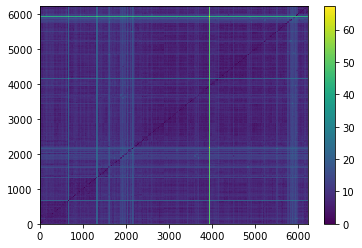

Method:	 single


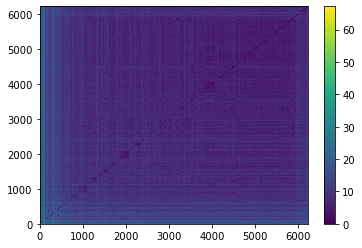

Method:	 average


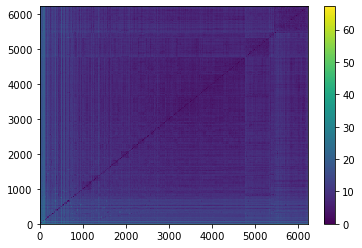

Method:	 complete


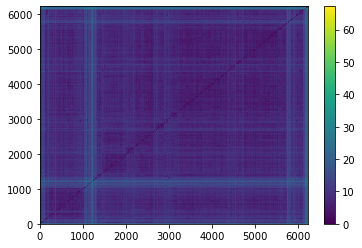

Method:	 weighted


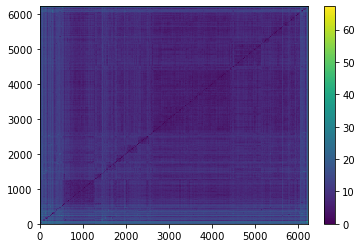

Method:	 centroid


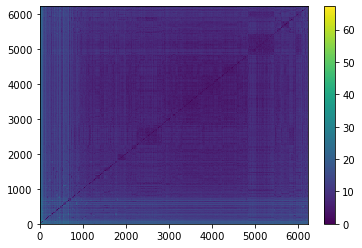

Method:	 median


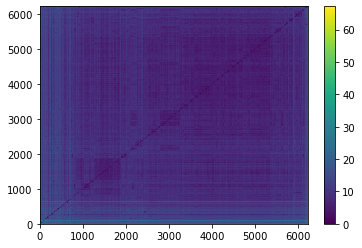

In [12]:
methods = ["ward","single","average","complete","weighted","centroid","median"]
for method in methods:
    print("Method:\t",method)
    
    ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(dist_mat_rand,method)
    
    plt.pcolormesh(ordered_dist_mat)
    plt.colorbar()
    plt.xlim([0,N])
    plt.ylim([0,N])
    plt.show()



In [13]:
# alternative approach with pyclustertend functions


def vat(data, return_odm=False, figure_size=(10, 10)):
    """VAT means Visual assesement of tendency. basically, it allow to asses cluster tendency
    through a map based on the dissimiliraty matrix.
    Parameters
    ----------
    data : matrix
        numpy array
    return_odm : return the Ordered Dissimalirity Matrix
        boolean (default to False)
    figure_size : size of the VAT.
        tuple (default to (10,10))
    Return
    -------
    ODM : matrix
        the ordered dissimalarity matrix plotted.
    """

    ordered_dissimilarity_matrix = compute_ordered_dissimilarity_matrix(data)

    _, ax = plt.subplots(figsize=figure_size)
    ax.imshow(
        ordered_dissimilarity_matrix,
        cmap="gray",
        vmin=0,
        vmax=np.max(ordered_dissimilarity_matrix),
    )

    if return_odm is True:
        return ordered_dissimilarity_matrix


def compute_ordered_dissimilarity_matrix(X):
    """The ordered dissimilarity matrix is used by visual assesement of tendency. It is a just a a reordering
    of the dissimilarity matrix.
    Parameters
    ----------
    X : matrix
        numpy array
    Return
    -------
    ODM : matrix
        the ordered dissimalarity matrix .
    """

    # Step 1 :

    observation_path = []

    matrix_of_pairwise_distance = pairwise_distances(X)
    list_of_int = np.zeros(matrix_of_pairwise_distance.shape[0], dtype="int")

    index_of_maximum_value = np.argmax(matrix_of_pairwise_distance)

    column_index_of_maximum_value = (
        index_of_maximum_value // matrix_of_pairwise_distance.shape[1]
    )

    list_of_int[0] = column_index_of_maximum_value
    observation_path.append(column_index_of_maximum_value)

    K = np.linspace(
        0,
        matrix_of_pairwise_distance.shape[0] - 1,
        matrix_of_pairwise_distance.shape[0],
        dtype="int",
    )
    J = np.delete(K, column_index_of_maximum_value)

    # Step 2 :

    for r in range(1, matrix_of_pairwise_distance.shape[0]):

        p, q = (-1, -1)

        mini = np.max(matrix_of_pairwise_distance)

        for candidate_p in observation_path:
            for candidate_j in J:
                if matrix_of_pairwise_distance[candidate_p, candidate_j] < mini:
                    p = candidate_p
                    q = candidate_j
                    mini = matrix_of_pairwise_distance[p, q]

        list_of_int[r] = q
        observation_path.append(q)

        ind_q = np.where(np.array(J) == q)[0][0]
        J = np.delete(J, ind_q)

    # Step 3

    ordered_matrix = np.zeros(matrix_of_pairwise_distance.shape)

    for column_index_of_maximum_value in range(ordered_matrix.shape[0]):
        for j in range(ordered_matrix.shape[1]):
            ordered_matrix[
                column_index_of_maximum_value, j
            ] = matrix_of_pairwise_distance[
                list_of_int[column_index_of_maximum_value], list_of_int[j]
            ]

    # Step 4 :

    return ordered_matrix


In [14]:
vat(X)

KeyboardInterrupt: 

Above is the ordered dissimilarity matrix. 

In [ ]:
vat(scaled_X)

Same again but with scaling, scaling is definitely important. But looks like things are fairly random (normally distributed) according to this VAT.

In [ ]:
# ivat

def ivat(data, return_odm=False, figure_size=(10, 10)):
    """iVat return a visualisation based on the Vat but more reliable and easier to
    interpret.
    Parameters
    ----------
    data : matrix
        numpy array
    return_odm : return the Ordered Dissimalirity Matrix
            boolean (default to False)
    figure_size : size of the VAT.
        tuple (default to (10,10))
    Return
    -------
    D_prim : matrix
        the ivat ordered dissimalarity matrix.
    """

    ordered_matrix = compute_ivat_ordered_dissimilarity_matrix(data)

    _, ax = plt.subplots(figsize=figure_size)
    ax.imshow(ordered_matrix, cmap="gray", vmin=0, vmax=np.max(ordered_matrix))

    if return_odm is True:
        return ordered_matrix

def compute_ivat_ordered_dissimilarity_matrix(X):
    """The ordered dissimilarity matrix is used by ivat. It is a just a a reordering
    of the dissimilarity matrix.
    Parameters
    ----------
    X : matrix
        numpy array
    Return
    -------
    D_prim : matrix
        the ordered dissimalarity matrix .
    """

    ordered_matrix = compute_ordered_dissimilarity_matrix(X)
    re_ordered_matrix = np.zeros((ordered_matrix.shape[0], ordered_matrix.shape[0]))

    for r in range(1, ordered_matrix.shape[0]):
        # Step 1 : find j for which D[r,j] is minimum and j ipn [1:r-1]

        j = np.argmin(ordered_matrix[r, 0:r])

        # Step 2 :

        re_ordered_matrix[r, j] = ordered_matrix[r, j]
        re_ordered_matrix[j, r] = ordered_matrix[r, j]

        # Step 3 : pour c : 1,r-1 avec c !=j
        c_tab = np.array(range(0, r))
        c_tab = c_tab[c_tab != j]

        for c in c_tab:
            re_ordered_matrix[r, c] = max(ordered_matrix[r, j], re_ordered_matrix[j, c])
            re_ordered_matrix[c, r] = re_ordered_matrix[r, c]

    return re_ordered_matrix

In [ ]:
ivat(scaled_X)

Not great! Most likely the pulse value ranges overlap each other too much. Can't tell them apart. 